# Задача 2
Пусть $$X_i = \beta_1+i\beta_2+\varepsilon_0+\ldots+\varepsilon_i,\, i= 0, 1, \ldots, n$$ - расстояния, которое проехал трамвай за $i$ секунд по показанию датчика. Здесь $\beta_1$ - начальное расстояние, $\beta_2$ - скорость трамвая, $\varepsilon_0$ - ошибка начального показания датчика. Трамвай едет с постоянной скоростью, и через каждую секунду датчик фиксирует расстояние, которое проехал трамвай. Отсчет времени идет от предыдущего замера, причем отсчет происходит с ошибкой. Для $i = 1, \ldots, n$ величина $\varepsilon_i$ есть ошибка приращения расстояния, то есть $\varepsilon_i = \varepsilon_i^t \beta_2,$ где $\varepsilon_i^t$ - ошибка отсчета времени. Все ошибки $\varepsilon_i$ независимы и распределены по закону $N(0, \sigma^2)$. 

Сведите задачу к линейной модели и найдите оценки наименьших квадратов для начального расстояния $\beta_1$ и скорости $\beta_2,$ а также несмещенную оценку для $\sigma^2,$ из которой выразите оценку дисперсии отсчета времени. 

Данные возьмите из файла Regression.csv. Сделайте выводы.

In [1]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex
from sklearn import cluster, datasets

In [2]:
X = datasets.load_svmlight_file('regression.csv')[1]
n = len(X)

### Оценка
Загрузим данные из файла в массив $X$ размера $n$. С точки зрения статистики $X$ - случайный вектор из ${\rm I\!R}^n$, представимый как $X = l + \varepsilon$, где $$l = \begin{pmatrix} \beta_1 \\ \beta_1 + \beta_2 \\ \ldots \\ \beta_1 + (n - 1)\beta_2\end{pmatrix}, \varepsilon = \begin{pmatrix} \varepsilon_0 \\ \varepsilon_0 + \varepsilon_1 \\ \ldots \\ \varepsilon_0 + \ldots +  \varepsilon_{n-1}\end{pmatrix}$$ 

$l$ - фиксированный неизвестный вектор истинных значений расстояний. $\varepsilon$ - случайный вектор ошибок, т.ч. $\forall  i$ $\varepsilon_i \sim \mathcal{N}(0, \sigma^2) \Rightarrow E\varepsilon_i = 0, D\varepsilon_i=\sigma^2 \Rightarrow E\varepsilon = \overline{0}, D\varepsilon = diag\begin{pmatrix} \sigma^2 \\ 2\sigma^2 \\ \ldots \\ (n - 1)\sigma^2 \end{pmatrix}$

Запишем теперь $l$ как $Z\theta$, где $$Z = \begin{pmatrix} 1 & 0 \\ 1 & 1 \\ \ldots & \ldots \\ 1 & n - 1 \end{pmatrix}, \theta = \begin{pmatrix} \beta_1 \\ \beta_2 \end{pmatrix}$$. 

Тогда задача по поиску $l$ сведена к поиску $\theta$, и мы получаем линейную модель. 

Оценкой по методу наименьших квадратов будет $\hat\theta = arg min \|X-Z\theta\|^2 = (Z^\top Z)^{-1}Z^\top X$. Последнее равенство легко доказывается через равенство в точке минимума нулю градиента. 

Посчитаем оценку на наших данных и построим график изменения расстояния для данных и для оценки.

In [3]:
# вычисление матрицы Z
Z = np.array([np.full(n, 1), np.arange(0, n)]).T 
# вычисление оценки theta
theta_est = np.linalg.inv(Z.T @ Z) @ Z.T @ X

# вычисление расстояний в каждый момент времени по оценке
distance_est = np.full(n, theta_est[0]) + np.arange(0, n) * theta_est[1]

# функция для построения графиков
def plot_distances(size=n, offset=0):
    x = np.arange(offset, offset + size)
    plt.figure(figsize=(10, 5))
    plt.plot(x, X[offset : offset + size], label='Данные')
    plt.plot(x, distance_est[offset : offset + size], label='Оценка')
    plt.title('Зависимость пройденного расстояния от времени')
    plt.xlabel("Время")
    plt.ylabel("Расстояние")
    plt.legend()
    plt.show()

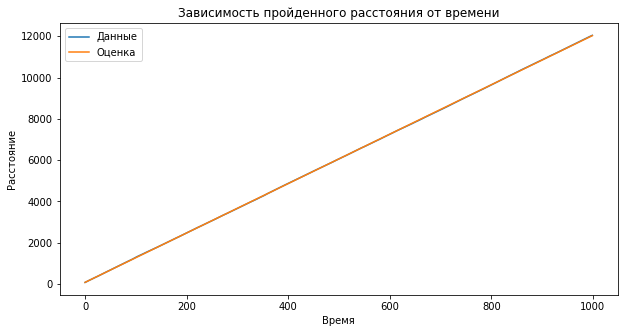

In [4]:
plot_distances()

#### Графики настолько близки, что может показаться, что линия одна. Их две. Взглянем поближе:

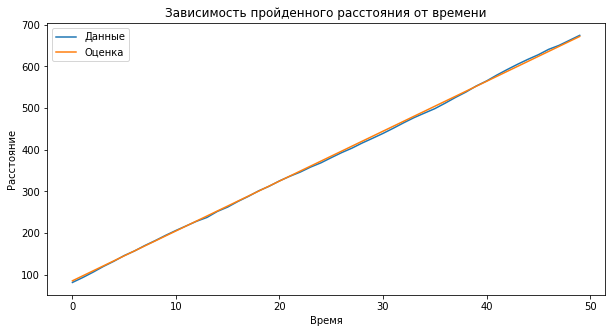

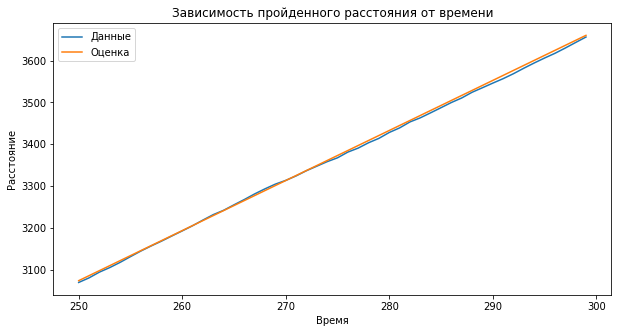

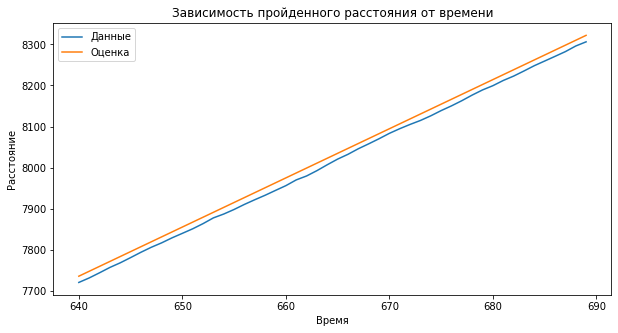

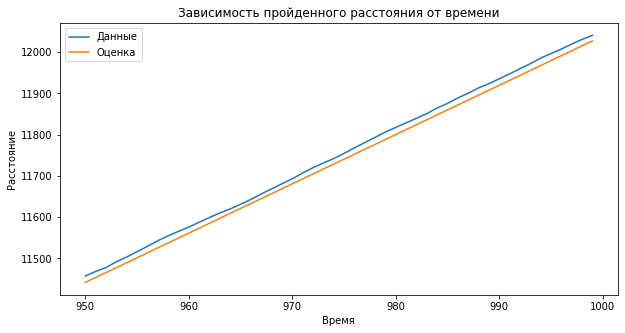

In [24]:
plot_distances(size=50)
plot_distances(size=50, offset=250)
plot_distances(size=50, offset=640)
plot_distances(size=50, offset=950)

#### Как мы видим, линии все-таки две. Они очень близки, но, конечно, не совпадают. Взглянем еще и на разность значений:

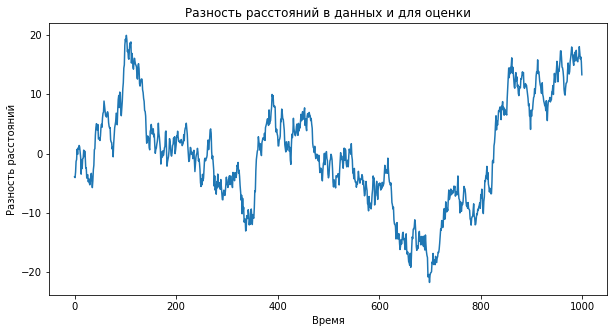

In [6]:
diff = X - distance_est
x = np.arange(0, 1000)
plt.figure(figsize=(10, 5))
plt.plot(x, diff)
plt.title('Разность расстояний в данных и для оценки')
plt.xlabel("Время")
plt.ylabel("Разность расстояний")
plt.show()

Нигде мы не промахнулись более, чем на 22 единицы расстояния. При общем расстоянии в 12000 результат скорее удовлетворительный, чем нет. Давайте теперь оценим дисперсию $\sigma^2$

### Дисперсия
Чтобы решить проблему того, что у $\varepsilon_i$ разные дисперсии - $\sigma^2 \cdot i$(мы в некотором смысле "накапливаем ошибки" - если мы несолько раз подряд ошибемся в одну сторону, результат можно сильно отклониться от верного, как, например, на графиках выше на отрезках $[640, 690]$ и $[950, 1000]$) - рассмотрим новый вектор $$X^{\ast} = \begin{pmatrix} X_1 - X_0 \\ X_2 - X_1 \\ \ldots \\ X_{n-1} - X_{n-2} \end{pmatrix}$$И соответствующие ему $l^{\ast} = (\beta_2, \ldots, \beta_2)^\top, \varepsilon^\ast = (\varepsilon_0, \varepsilon_1, \ldots, \varepsilon_{n-1})^\top$. Здесь у вектора $\varepsilon^\ast$ дисперсия по каждой координате $\sigma^2$. Оценим $\hat\sigma^2 = \frac{1}{n-2}\|X^\ast - l^\ast\|^2$. Для модели с нашими параметрами такая оценка будет эффективной. Для сравнения также посмотрим на выборочную дисперсию.

In [17]:
X_star = X[1:] - X[:-1]
l_star = np.full(n-1, theta_est[1])
eps_star = X_star - l_star
var_opt = np.linalg.norm(eps_star) ** 2 / (n - 2)
print(f'E = {np.mean(eps_star)}, sample variance = {np.var(eps_star)},\
 optimal variance estimate = {var_opt}')

E = 0.017265552025350205, sample variance = 1.5237180999706548, optimal variance estimate = 1.525543269597332


### Оценка дисперсии $\varepsilon_i^t$
$\varepsilon_i^t = \frac{\varepsilon_i}{\beta_2} \Rightarrow D\varepsilon_i^t = \frac{1}{\beta_2^2}D\varepsilon_i$

In [19]:
print(f'Time variance estimate = {var_opt / theta_est[1] ** 2}')

Time variance estimate = 0.010676602943192143


## Вывод
Если у нас есть серия измерений некоторых наборов неизвестных величин, которые могут проводиться с некоторой ошибкой, то можно воспользоваться техникой линейной регрессии. Элегантная интерпретация задачи как линейной модели, использование метода наименьших квадратов и немного матричной минимизации даруют нам некоторую оценку параметров модели. Как мы увидели, очень неплохую оценку - по крайней мере в похожих задачах, которыми, предположим, можно назвать задачи, сводящиеся к гауссовской линейной модели. 